# Global static map with Cartopy
In this tutorial we will create a global map showing the connections between major airports around the world. Among other libraries we use in this tutorial, we will work with Cartopy to visualize our geospatial data. [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is a Python library designed for cartography and geographic data processing. It's built on top of Matplotlib and provides a powerful interface for creating maps and visualizing geospatial data. With Cartopy, you can easily manipulate and project geographic datasets onto different map projections, draw maps for different regions of the world, and overlay data points, lines, and polygons. Whether you're working on complex geospatial analysis, creating detailed maps for a presentation, or just exploring the world's geography, Cartopy offers good tools to bring your geographic data to life. 

In [21]:
from IPython.display import IFrame
documentation = IFrame(src='https://scitools.org.uk/cartopy/docs/latest/#', width=1000, height=400)
display(documentation)

### Data
In this tutorial we will work with the airports data from [Openflights.org](https://openflights.org/). This includes a rich database of airports around the world as well as information such as the geographical locations and global connections.

### Let's get started!

In this course we will use the [pathlib](https://docs.python.org/3/library/pathlib.html) library to manage our paths.  This library provides an abstract layer on top of the actual operating system file paths that is consistent across computers. A ´pathlib.Path()´ object can be initiated with a file path (as a str), when created without an argument, it refers to the directory of the script or notebook file. For review of how to use pathlib, please refer to the [AutoGIS course webpages](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-2/managing-file-paths.html).

In [24]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [48]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [26]:
airports = pd.read_csv(DATA_DIRECTORY / "airports.dat", delimiter=',', 
                       names=['id', 'name', 'city', 'country', 'iata', 
                              'icao', 'lat', 'long', 'altitude', 'timezone',
                              'dst', 'tz', 'type', 'source'])

In [28]:
airports.head()

id                                         name          city  \
0   1                               Goroka Airport        Goroka   
1   2                               Madang Airport        Madang   
2   3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3   4                               Nadzab Airport        Nadzab   
4   5  Port Moresby Jacksons International Airport  Port Moresby   

            country iata  icao       lat        long  altitude timezone dst  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998      5282       10   U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001        20       10   U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005      5388       10   U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977       239       10   U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001       146       10   U   

                     tz     type       source  
0  Pacific/Port_Moresby  airport  OurAirports  
1  Pacific/Port_Moresby  airport  OurAirports  
2  Pacific/Port_Moresby  airport  OurAirports  
3  Pacific/Port_Moresby  airport  OurAirports  
4  Pacific/Port_Moresby  airport  OurAirports

In [29]:
airports.columns

Index(['id', 'name', 'city', 'country', 'iata', 'icao', 'lat', 'long',
       'altitude', 'timezone', 'dst', 'tz', 'type', 'source'],
      dtype='object')

In [30]:
# Create Point geometries from airport longitude and latitude
airport_geometry = [Point(xy) for xy in zip(airports['long'], 
                                            airports['lat'])]

# Create a GeoDataFrame from the airports data
airport_geodata = gpd.GeoDataFrame(airports, 
                                   crs="EPSG:4326", 
                                   geometry=airport_geometry)

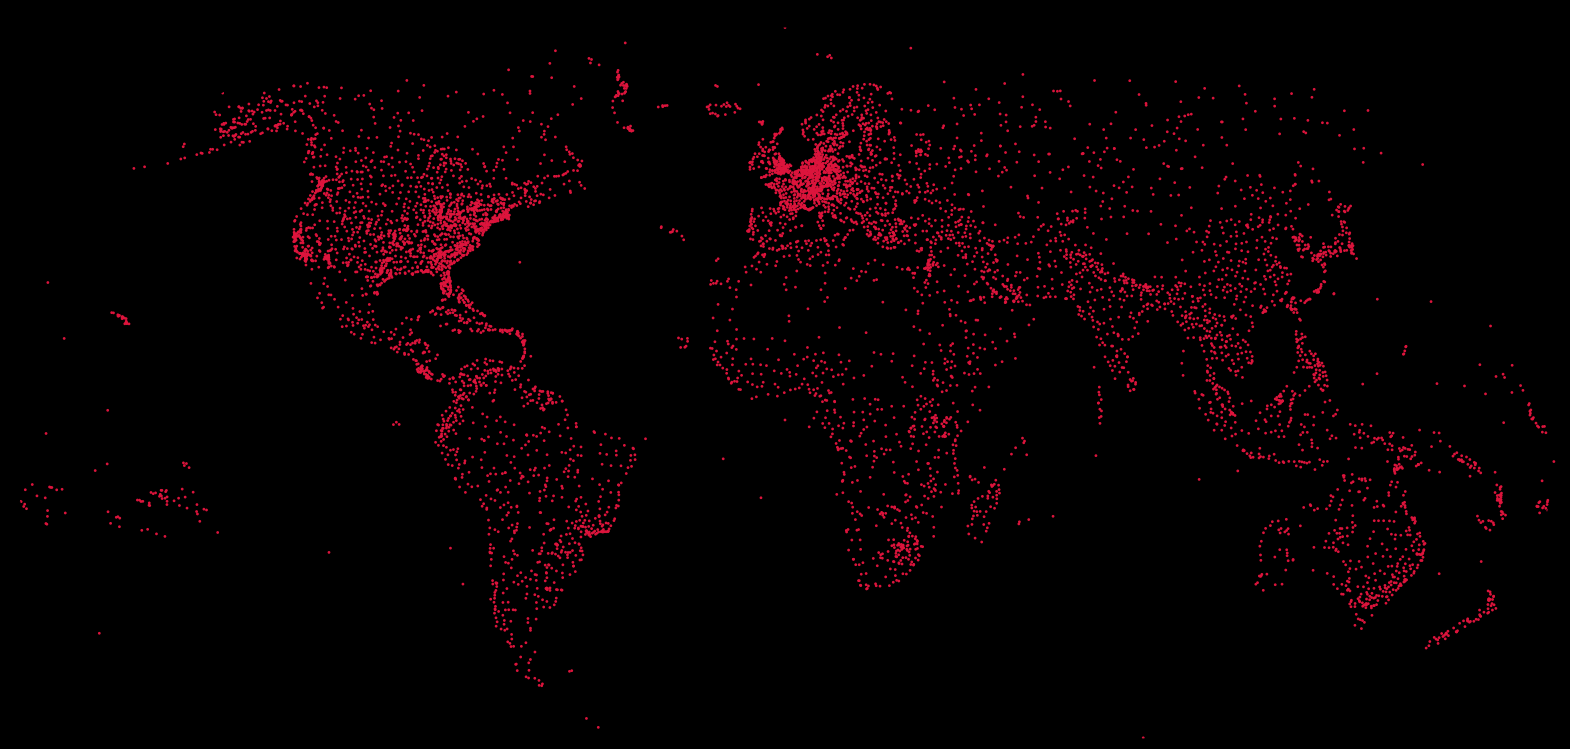

In [7]:
# Create a quick plot of our data
fig, ax = plt.subplots(facecolor='black', 
                       subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
ax.patch.set_facecolor('black')

airport_geodata.plot(ax=ax, transform=ccrs.PlateCarree(), 
                     markersize=4, alpha=1, color='crimson', 
                     edgecolors='none')
plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 9000000)
plt.show()

In [32]:
routes = pd.read_csv(DATA_DIRECTORY / "routes.dat", 
                     delimiter=',', 
                     names=['airline', 'id', 'source_airport', 
                            'source_airport_id', 'destination_airport', 
                            'destination_airport_id', 'codeshare',
                            'stops', 'equitment'])
routes.head()

airline   id source_airport source_airport_id destination_airport  \
0      2B  410            AER              2965                 KZN   
1      2B  410            ASF              2966                 KZN   
2      2B  410            ASF              2966                 MRV   
3      2B  410            CEK              2968                 KZN   
4      2B  410            CEK              2968                 OVB   

  destination_airport_id codeshare  stops equitment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2

In [33]:
# Select relevant columns for source airports and create a new DataFrame
source_airports = airports[['name', 'iata', 'icao', 'lat', 'long']]

# Copy the source airports DataFrame to create a separate DataFrame for destination airports
destination_airports = source_airports.copy()

# Rename columns of the source airports DataFrame to indicate they are source attributes
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]

# Rename columns of the destination airports DataFrame to indicate they are destination attributes
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]


In [34]:
# Filter the routes DataFrame to include only source and destination airport identifiers
routes = routes[['source_airport', 'destination_airport']]

# Merge the filtered routes DataFrame with source_airports on their IATA codes to add source airport details
routes = pd.merge(routes, 
                  source_airports, 
                  left_on='source_airport',  # Column in routes DataFrame to match
                  right_on='iata_source')    # Corresponding column in source_airports DataFrame

# Merge the updated routes DataFrame with destination_airports on their IATA codes to add destination airport details
routes = pd.merge(routes, 
                  destination_airports, 
                  left_on='destination_airport',  # Column in routes DataFrame to match
                  right_on='iata_destination')    # Corresponding column in destination_airports DataFrame


In [35]:
# Check the columns in our joined data
routes.columns

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')

### Creating line objects to represent flight routes
Now that we did some data preparation, we use Shapely library to visualize flight routes between airports on a map. You ca refresh your memory of Shapely library from [AutoGIS course page](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-1/geometry-objects.html) Here's a step-by-step breakdown of what each part of the code is doing:

1. **Import LineString from Shapely**: `LineString` is a geometric object consisting of multiple points to form a line. We import it to represent the flight routes geometrically.

2. **Create LineString Objects for Each Route**:
    - We iterate over each row in the `routes` DataFrame, which contains information about each flight route, including the source and destination airports' coordinates (`long_source`, `lat_source`, `long_destination`, `lat_destination`).
    - For every route, we create a `LineString` object that connects the source airport to the destination airport using their longitude and latitude coordinates. This effectively draws a line between the two points on the map.

3. **Create a GeoDataFrame for Routes**:
    - With the list of `LineString` objects (each representing a flight route), we create a new GeoDataFrame called `routes_geodata`. This GeoDataFrame contains all the original route information, plus a new `geometry` column where each entry is a `LineString` object corresponding to that route.
    - We also specify the coordinate reference system (CRS) as 'EPSG:4326' to ensure our geometries are properly aligned on a global map. This CRS corresponds to the widely used WGS 84 latitude-longitude coordinate system.

By transforming our route data into a GeoDataFrame with line geometries, we can easily visualize these flight paths on a map, providing a clear and informative visual representation of air travel connections.


In [39]:
from shapely.geometry import LineString

routes_geometry = [LineString([[routes.iloc[i]['long_source'], 
                                routes.iloc[i]['lat_source']], 
                               [routes.iloc[i]['long_destination'], 
                                routes.iloc[i]['lat_destination']]]) 
                   for i in range(routes.shape[0])]

routes_geodata = gpd.GeoDataFrame(routes, 
                                  geometry=routes_geometry, 
                                  crs='EPSG:4326')
routes.head()

source_airport destination_airport                    name_source  \
0            AER                 KZN    Sochi International Airport   
1            ASF                 KZN              Astrakhan Airport   
2            ASF                 MRV              Astrakhan Airport   
3            CEK                 KZN  Chelyabinsk Balandino Airport   
4            CEK                 OVB  Chelyabinsk Balandino Airport   

  iata_source icao_source  lat_source  long_source  \
0         AER        URSS   43.449902    39.956600   
1         ASF        URWA   46.283298    48.006302   
2         ASF        URWA   46.283298    48.006302   
3         CEK        USCC   55.305801    61.503300   
4         CEK        USCC   55.305801    61.503300   

              name_destination iata_destination icao_destination  \
0  Kazan International Airport              KZN             UWKD   
1  Kazan International Airport              KZN             UWKD   
2     Mineralnyye Vody Airport              MRV             URMM   
3  Kazan International Airport              KZN             UWKD   
4           Tolmachevo Airport              OVB             UNNT   

   lat_destination  long_destination  
0        55.606201         49.278702  
1        55.606201         49.278702  
2        44.225101         43.081902  
3        55.606201         49.278702  
4        55.012600         82.650703

Now let's make a quick plot to see what we have:

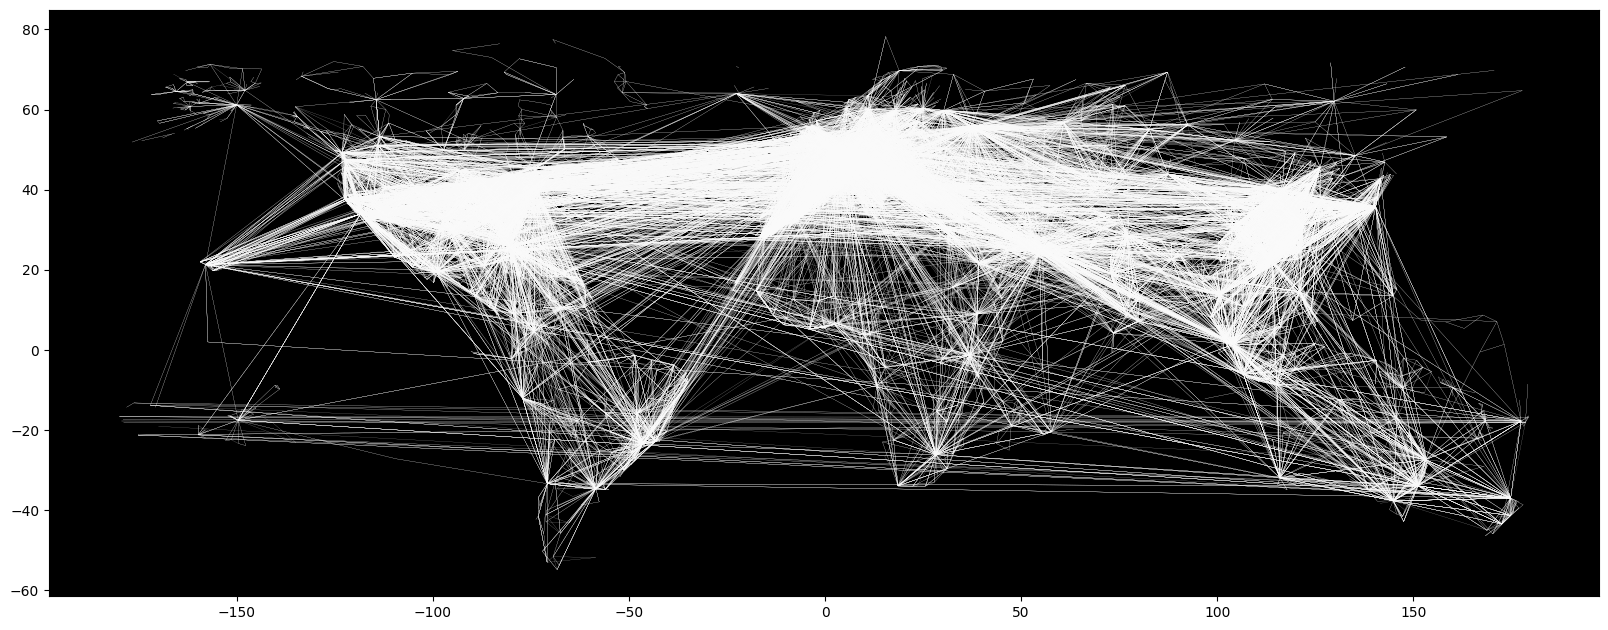

In [15]:
fig, ax = plt.subplots(figsize=(20,20))
ax.patch.set_facecolor('black')

routes_geodata.plot(ax=ax, color='white', linewidth=0.1)

plt.show()

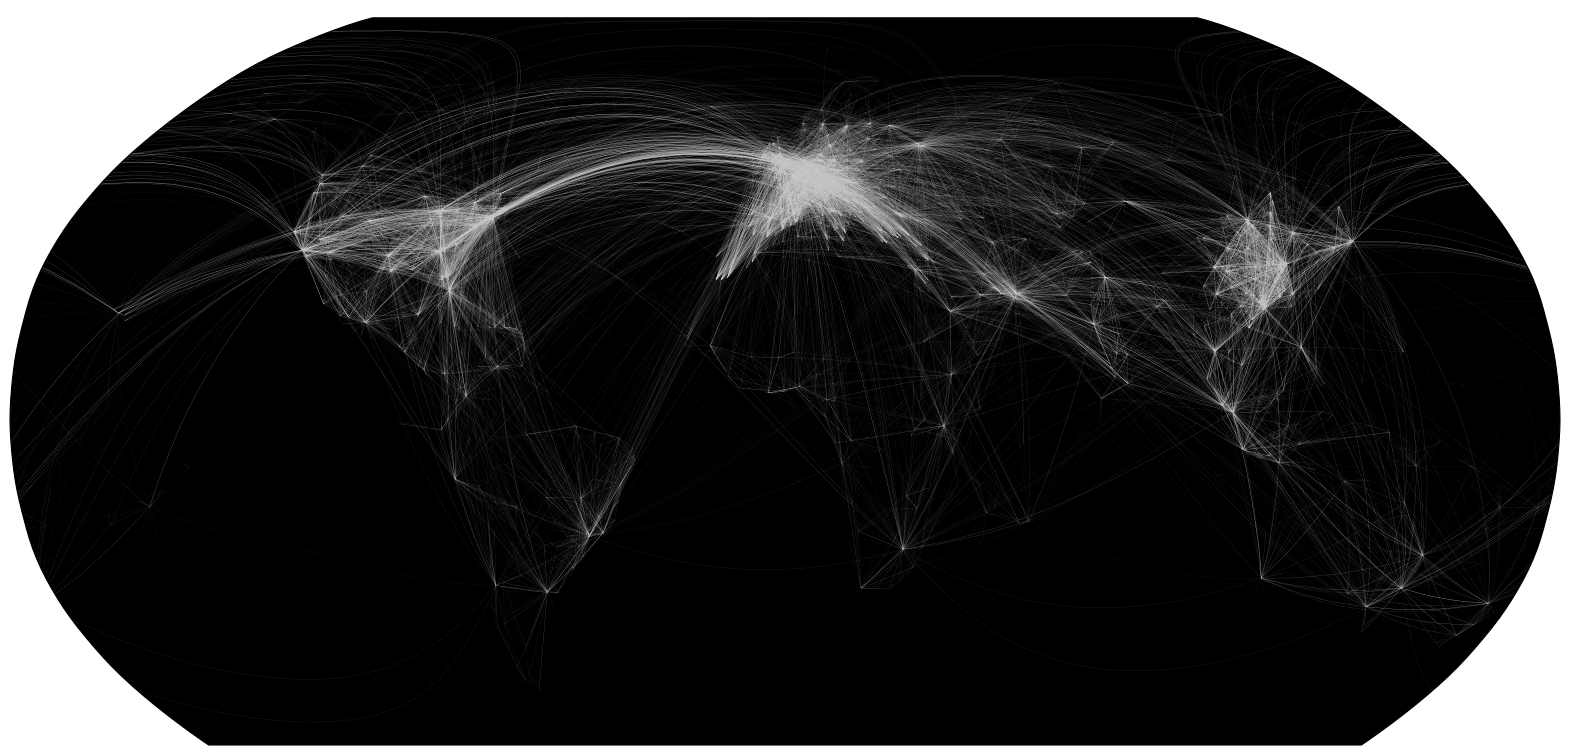

In [40]:
# Create a figure and axis with a Robinson projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))  # Set the size of the map

ax.patch.set_facecolor('black')  # Set the background color of the map to black

# Plot the routes on the map
routes_geodata.plot(ax=ax, 
                    transform=ccrs.Geodetic(),  # Ensure the data uses a geodetic (lat/lon) projection
                    color='white',  # Set the color of the routes to white
                    linewidth=0.1,  # Set the width of the lines representing the routes
                    alpha=0.1)  # Set the transparency of the routes

# Change the color of the map's border to black
plt.setp(ax.spines.values(), color='black')

# Change the color of the tick lines on the map to black
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')

# Set the y-axis limits to adjust the visible area of the map projection
ax.set_ylim(-7000000, 8800000)

# Display the plot
plt.show()


Let's now add the aiport locations to the map. At the same time, we would like to show the number of flights per each airport. Why not do both at the same time using a **proportional symbol map**? For doing so, we need to do a bit more data preparation. 

In [41]:
# Count the number of occurrences of each airport as a source airport
airport_source_count = routes.source_airport.value_counts()

# Count the number of occurrences of each airport as a destination airport
airport_destination_count = routes.destination_airport.value_counts()

# Display the counts of source airports
airport_source_count.head()

source_airport
ATL    915
ORD    558
LHR    527
PEK    525
CDG    524
Name: count, dtype: int64

In [43]:
# Convert the series of source airport counts into a DataFrame with two columns: 'airport' and 'source_airport_count'
airport_source_count = pd.DataFrame({'airport': airport_source_count.index, 
                                     'source_airport_count': airport_source_count.values})

# Convert the series of destination airport counts into a DataFrame with two columns: 'airport' and 'destination_airport_count'
airport_destination_count = pd.DataFrame({'airport': airport_destination_count.index, 
                                          'destination_airport_count': airport_destination_count.values})

# Merge the two DataFrames on the 'airport' column to combine source and destination counts for each airport
airport_counts = pd.merge(airport_source_count, 
                          airport_destination_count, 
                          on="airport")

In [44]:
# Calculate the total count (sum of source and destination counts) for each airport
airport_counts['count'] = airport_counts['source_airport_count'] + airport_counts['destination_airport_count']

# Merge the combined counts DataFrame with the airports DataFrame to add additional airport information
airport_counts = pd.merge(airport_counts, 
                          airports, 
                          left_on="airport",  # Key in airport_counts DataFrame
                          right_on="iata")    # Corresponding key in airports DataFrame

# Create Point geometries from airport longitude and latitude for geospatial visualization
geometry = [Point(xy) for xy in zip(airport_counts.long, airport_counts.lat)]

# Convert the airport_counts DataFrame into a GeoDataFrame
airport_counts = gpd.GeoDataFrame(airport_counts, 
                                  geometry=geometry,  
                                  crs="EPSG:4326")    

# Calculate marker size based on the airport 'count' to visualize the airport traffic volume
airport_counts['markersize'] = airport_counts['count'] / 10  # Scale down the count for a suitable marker size


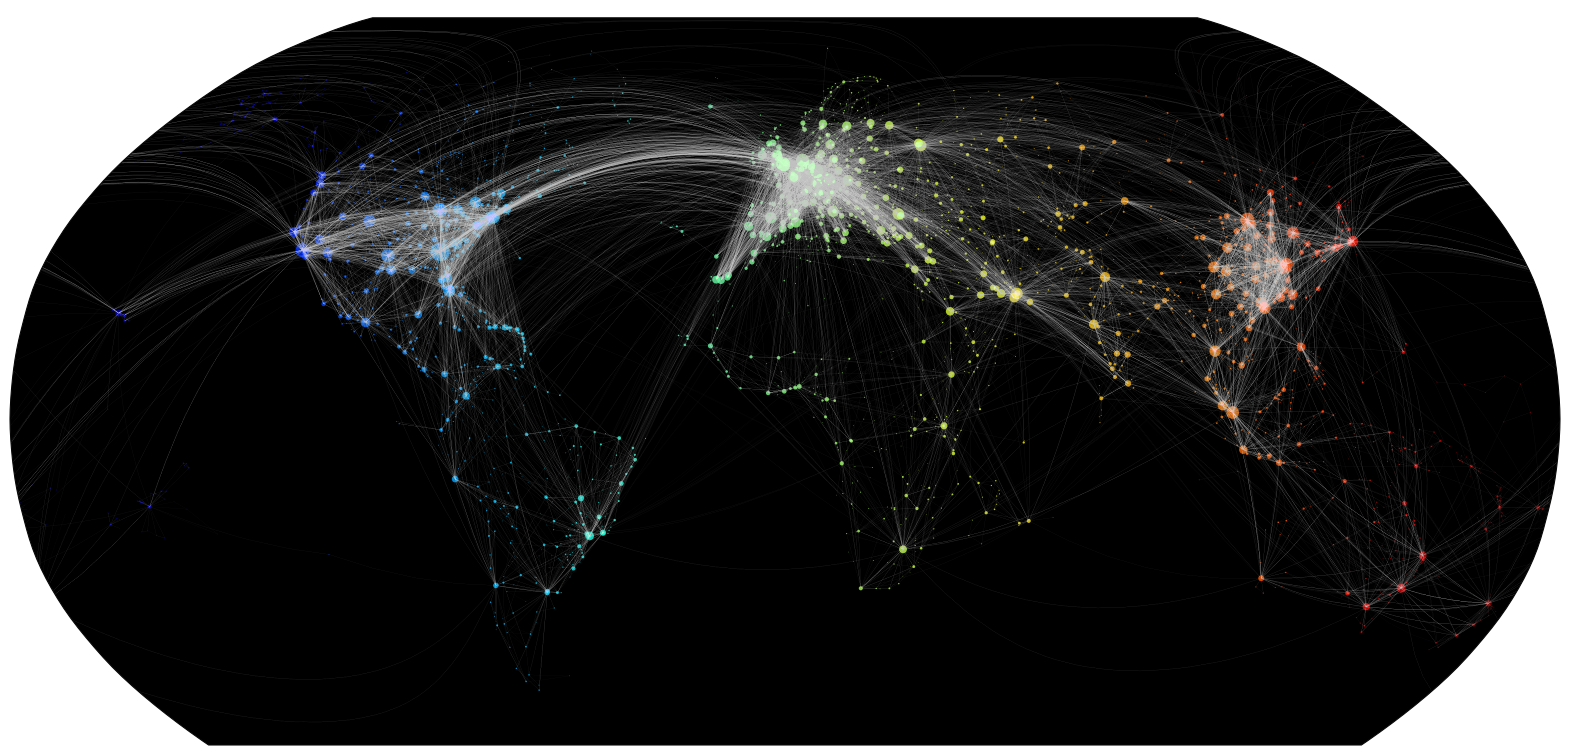

In [46]:
# Create a figure and axis with a Robinson projection, setting the size of the map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))

# Set the background color of the map to black
ax.patch.set_facecolor('black')

# Plot the routes on the map with specific visual attributes
routes_geodata.plot(ax=ax, 
                    transform=ccrs.Geodetic(),  # Ensure the data uses the Geodetic (latitude/longitude) projection
                    color='white',  # Set the routes color to white for contrast
                    linewidth=0.1,  # Specify the line width for the routes
                    alpha=0.1)  # Set the transparency level of the routes

# Plot the airports on the map, using the 'markersize' to represent traffic volume
airport_counts.plot(ax=ax, 
                    transform=ccrs.PlateCarree(),  # Use PlateCarree projection for airport points
                    markersize=airport_counts['markersize'],  # Set marker size based on airport traffic volume
                    alpha=0.8,  # Set the transparency level of the airport markers
                    column=airport_counts['long'],  # Use the longitude for coloring (not typically meaningful, could be adjusted)
                    cmap='jet',  # Color map for the airports
                    edgecolors='none')  # No edge colors for the markers

# Set the color of the map's border to a dark gray for aesthetic purposes
plt.setp(ax.spines.values(), color='#090909')

# Set the color of the tick lines on the map to dark gray for consistency
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#090909')

# Adjust the y-axis limits to better fit the projection's display area
ax.set_ylim(-7000000, 8800000)

# Display the plot
plt.show()


<div style="background-color: #f9f9f9; border-left: 6px solid #2196F3; margin: 20px 0; padding: 15px 20px;">
    <h4>Why Use Different Projections for Routes and Airports?</h4>
    <p>Using two different projections for routes (<code>ccrs.Geodetic()</code>) and airports (<code>ccrs.PlateCarree()</code>) in the code primarily relates to the way Cartopy handles the transformation of data when plotting on a map projection, such as <code>ccrs.Robinson()</code>.</p>
    <ol>
        <li><strong>Routes (Lines) with <code>ccrs.Geodetic()</code>:</strong>
            <ul>
                <li>When plotting lines that span significant portions of the globe (like flight routes), using the <code>ccrs.Geodetic()</code> transform ensures that the lines are correctly drawn as the shortest paths between two points on the globe's surface, taking into account the Earth's curvature. This is especially important for long-distance routes, which might not appear as straight lines on certain map projections due to the spherical nature of the Earth.</li>
                <li>The <code>ccrs.Geodetic()</code> transform tells Cartopy to interpret the line endpoints in geographical coordinates (latitude and longitude) and to plot the "great circle" path between them, which represents the shortest distance between those points on the Earth's surface.</li>
            </ul>
        </li>
        <li><strong>Airports (Points) with <code>ccrs.PlateCarree()</code>:</strong>
            <ul>
                <li>The <code>ccrs.PlateCarree()</code> projection is essentially a simple map projection where the latitude and longitude are directly mapped to a grid. This makes it straightforward for plotting point data that is already given in latitude and longitude, as is typically the case with airport locations.</li>
                <li>Using <code>ccrs.PlateCarree()</code> for points does not have the same implications as for lines, since points are just single locations on the map. The transformation is used to ensure that these points are accurately placed according to their latitude and longitude on the projected map.</li>
            </ul>
        </li>
    </ol>
    <p>In essence, the choice of <code>ccrs.Geodetic()</code> for routes and <code>ccrs.PlateCarree()</code> for airports optimizes the accuracy and visual correctness of the plotted data. It ensures that routes are drawn as realistically as possible, accounting for the Earth's curvature, while airports are accurately positioned according to their geographic coordinates. This approach leverages the strengths of different transformations for the specific types of geospatial data being visualized.</p>
</div>


Let's still improve the map: 
- We will add a **legend** to the map, enhancing interpretability by attempting to distinguish between routes and airports visually.
- Add a **title** to show to the viewer what the map is about. 
- We apply the **colormap** to the airport markers based on their longitude, adding a visual dimension to the data. (this could have also been used to still add one more variable to the map)


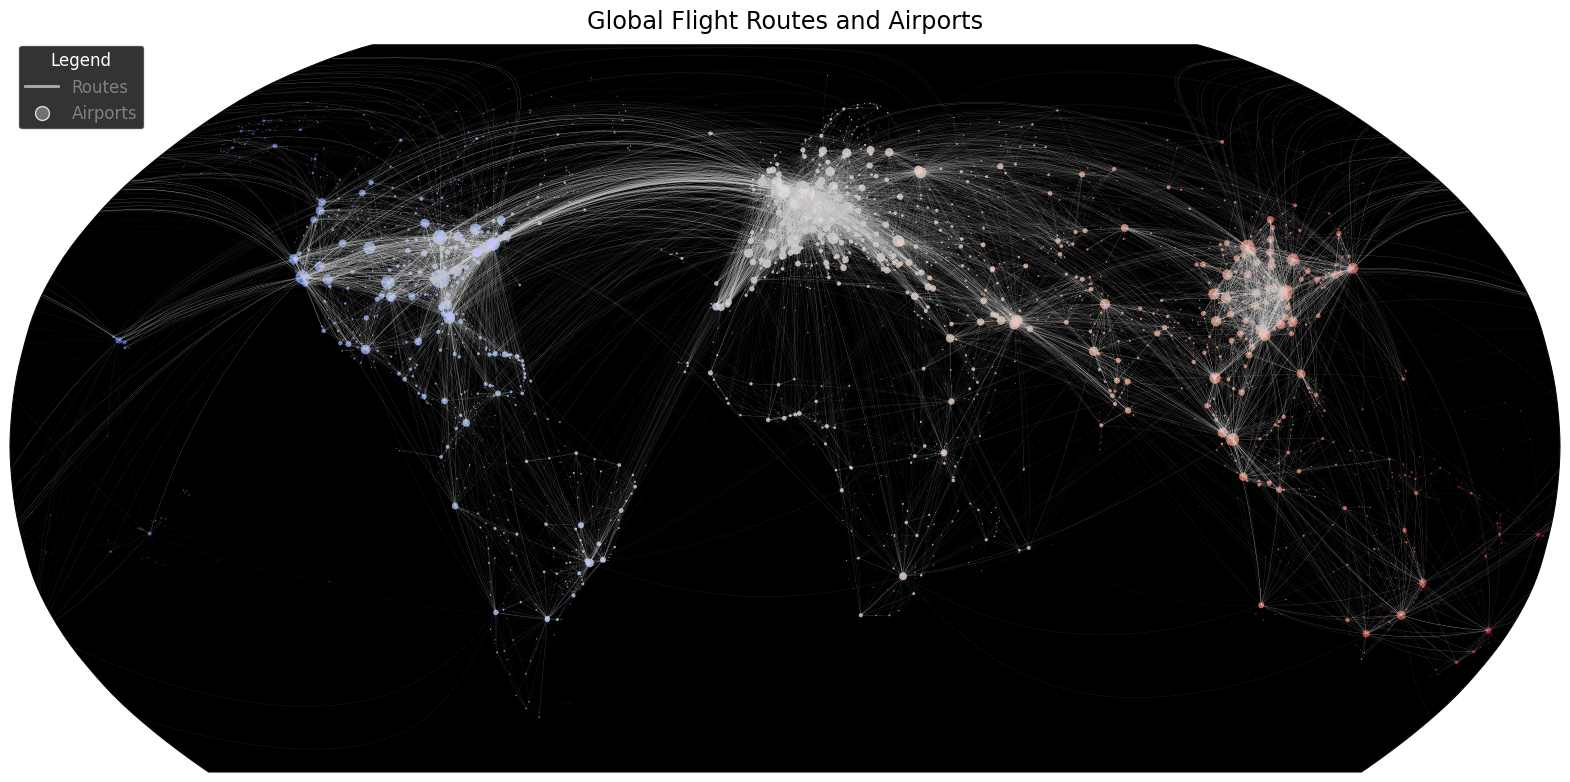

In [66]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Initialize a figure with a Robinson projection and set the figure size and background color
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(20, 20))
ax.patch.set_facecolor('black')

# Plot the flight routes with specified visual attributes for a subtle background effect
routes_geodata.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.1, alpha=0.1)

# Plot the airport counts with adjusted marker size and colormap
scatter = airport_counts.plot(ax=ax, transform=ccrs.PlateCarree(), markersize=airport_counts['markersize'],
                              alpha=0.8, column=airport_counts['long'], cmap='coolwarm', edgecolors='none')

# Customize the appearance of the plot's borders and tick lines to match the dark theme
plt.setp(ax.spines.values(), color='#090909')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#090909')

# Adjust the vertical (y-axis) limits of the map to focus on the main areas of interest
ax.set_ylim(-7000000, 8800000)

# Manually create legend entries
legend_elements = [
    Line2D([0], [0], color='white', lw=2, alpha=0.6, label='Routes'), 
    Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='grey', alpha=0.8, label='Airports', linestyle='None') 
]

# Create the legend with the custom entries, specifying location and style without using 'title_color'
legend = ax.legend(handles=legend_elements, loc='upper left', facecolor='black', edgecolor='white', fontsize='large', title='Legend', title_fontsize='large')

# Set the legend title color after the legend has been created
legend.get_title().set_color("white")

# Set individual text colors for the legend items
legend.get_texts()[0].set_color('grey')  # Set color for the "Routes" legend item
legend.get_texts()[1].set_color('grey')  # Set color for the "Airports" legend item

# Add a title to the map
ax.set_title("Global Flight Routes and Airports", fontsize='xx-large', color='black', loc='center')

# Proceed to display the plot as before
plt.show()
